In [1]:
import numpy as np
from numpy.random import seed
from numpy.random import randint
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pandas as pd
import wordcloud
import json
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from pprint import pprint
import re
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import nltk
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
import funciones as fn
import datetime
import ast

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Vamos a realizar una transformación usando Graph Api v4.0
Una base de datos que funciona así: reshape - comments to wide

# Caso: Tenemos los comments en una columna

In [2]:
path = r'D:\Trabajo\Barómetro\BX\Facebook'
df_original = pd.read_excel(path + '\\' + 'facebook_vv_ago_nov_1.xlsx')
df_original = df_original[df_original['level'] == 1]

In [3]:
df_original.dropna(subset=['message'], inplace=True)
df_original[['id','parent_id','message','level','created_time']].head(10)

,id,parent_id,message,level,created_time
0,2,1,🚨¡No caigas en estafas! 🚨 📆 Aún no hay fechas...,1,2022-11-22 17:37:25
1,3,1,‼️¡No te peles el Entregatón!‼️ 🔋 Ponte las p...,1,2022-11-21 17:53:07
2,4,1,👋¡Epa mi pana!👋 ⏰ Luego de 5 años con tu PPT ...,1,2022-11-20 17:20:02
3,5,1,🤤 ¿Alguien más se siente así o solo nosotros? ...,1,2022-11-19 17:20:01
4,6,1,⁉️¿Quieres abrir una cuenta digital y tener un...,1,2022-11-18 17:29:42
5,7,1,🌸¡Una ayuda para las mamitas! 🌸 🔊 Activa el a...,1,2022-11-17 18:45:14
6,8,1,👀 ¡Conoce tus derechos y beneficios cuando ere...,1,2022-11-16 17:20:01
7,9,1,👋 ¡Hey hey! 👋 👀 Si requieres de algunos de es...,1,2022-11-15 17:28:39
8,10,1,"⁉️¿Estás siendo abusad@ de manera laboral, agr...",1,2022-11-14 17:29:56
9,11,1,⁉️¿Sabías este dato? ¿Tienes más dudas sobre e...,1,2022-11-13 17:32:01


In [32]:
df = df_original.copy()
df['message'] = df['message'].str.encode('utf8','surrogateescape').str.decode('utf8','surrogateescape')
df['fecha'] = df['created_time'].apply(lambda a: pd.to_datetime(a).date())
df['dia'] = df['fecha'].apply(lambda a: pd.to_datetime(a).day)
df['mes'] = df['fecha'].apply(lambda a: pd.to_datetime(a).month)
df['combinado'] = df["dia"].astype(str) + '_' + df["mes"].astype(str)
df[['id','parent_id','message','level','created_time','fecha','dia','mes','combinado']].head(10)

,id,parent_id,message,level,created_time,fecha,dia,mes,combinado
0,2,1,🚨¡No caigas en estafas! 🚨 📆 Aún no hay fechas...,1,2022-11-22 17:37:25,2022-11-22,22,11,22_11
1,3,1,‼️¡No te peles el Entregatón!‼️ 🔋 Ponte las p...,1,2022-11-21 17:53:07,2022-11-21,21,11,21_11
2,4,1,👋¡Epa mi pana!👋 ⏰ Luego de 5 años con tu PPT ...,1,2022-11-20 17:20:02,2022-11-20,20,11,20_11
3,5,1,🤤 ¿Alguien más se siente así o solo nosotros? ...,1,2022-11-19 17:20:01,2022-11-19,19,11,19_11
4,6,1,⁉️¿Quieres abrir una cuenta digital y tener un...,1,2022-11-18 17:29:42,2022-11-18,18,11,18_11
5,7,1,🌸¡Una ayuda para las mamitas! 🌸 🔊 Activa el a...,1,2022-11-17 18:45:14,2022-11-17,17,11,17_11
6,8,1,👀 ¡Conoce tus derechos y beneficios cuando ere...,1,2022-11-16 17:20:01,2022-11-16,16,11,16_11
7,9,1,👋 ¡Hey hey! 👋 👀 Si requieres de algunos de es...,1,2022-11-15 17:28:39,2022-11-15,15,11,15_11
8,10,1,"⁉️¿Estás siendo abusad@ de manera laboral, agr...",1,2022-11-14 17:29:56,2022-11-14,14,11,14_11
9,11,1,⁉️¿Sabías este dato? ¿Tienes más dudas sobre e...,1,2022-11-13 17:32:01,2022-11-13,13,11,13_11


In [33]:
df['comments'].fillna('',inplace=True)
for index, row in df.iterrows():
    df.loc[index, 'comments'] = row['comments'][row['comments'].find("["):row['comments'].find("]")+1]
print(df.comments)
print(df.comments[1])
def f(x):
    try:
        return list(ast.literal_eval(str(x)))   
    except Exception as e:
        print(e)
        return []
df['comments'] = df.comments.apply(lambda x: f(x))   
base = pd.DataFrame({"id_post_vv":[], "id":[], "level":[], "message":[], "fecha":[]})
# Para cada fila agarro el post vigente y su id...
id_post_vv = list()
id_post= list()
level= list()
message= list()
fecha= list()
for index, row in df.iterrows():
    id_post_vv.append(index)
    id_post.append(index)
    level.append(1)
    fecha.append(row['created_time'])
    message.append(row['message'].encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
    i = 0
    for item in row['comments']:
        id_post_vv.append(index)
        id_post.append(i)
        i += 1
        level.append(2)
        item = dict(item)
        fecha.append(item.get('created_time'))
        try:
            message.append(item.get('message').encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
        except:
            try:
                message.append(json.loads(repr(item.get('message'))).encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
            except:
                try:
                    message.append(json.loads(repr(item.get('message'))).encode('unicode-escape').decode('ascii'))
                except:
                    message.append(repr(item.get('message').split('\\')[0]).encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
                    continue
base['id_post_vv'] = id_post_vv
base['id'] = id_post
base['fecha'] = fecha
base['fecha'] = base['fecha'].apply(lambda a: pd.to_datetime(a).date()) 
base['level'] = level
base['message'] = message
base.head(5)

0     [{"created_time": "2022-11-22T23:22:56+0000", ...
1     [{"created_time": "2022-11-22T00:35:47+0000", ...
2     [{"created_time": "2022-11-20T22:28:50+0000", ...
3     [{"created_time": "2022-11-21T03:40:59+0000", ...
4     [{"created_time": "2022-11-18T22:35:27+0000", ...
                            ...                        
95    [{"created_time": "2022-08-04T23:34:53+0000", ...
96    [{"created_time": "2022-08-04T18:52:36+0000", ...
97    [{"created_time": "2022-08-03T22:09:20+0000", ...
98    [{"created_time": "2022-08-02T18:33:06+0000", ...
99    [{"created_time": "2022-08-01T23:02:00+0000", ...
Name: comments, Length: 100, dtype: object
[{"created_time": "2022-11-22T00:35:47+0000", "message": "Yo fui y lo que me dijeron fue si no le a llegado el el mensaje hay que esperar si m\u00ed permiso ya est\u00e1 impreso hace rato \nSi no les a llegado el mensaje ni vallan a perder tiempo pasaje"}, {"created_time": "2022-11-22T06:44:03+0000", "message": "Hola s\u00e9 que el tema es

,id_post_vv,id,level,message,fecha
0,0,0,1,🚨¡No caigas en estafas! 🚨 📆 Aún no hay fechas...,2022-11-22
1,0,0,2,Cual es la.pagina de la embajada y que tramite...,2022-11-22
2,1,1,1,‼️¡No te peles el Entregatón!‼️ 🔋 Ponte las p...,2022-11-21
3,1,0,2,Yo fui y lo que me dijeron fue si no le a lleg...,2022-11-22
4,1,1,2,Hola sé que el tema es distinto pero me gustar...,2022-11-22


In [38]:
base_graficas = base.copy()
base_graficas['Menciones'] = 1
base_graficas

,id_post_vv,id,level,message,fecha,Menciones
0,0,0,1,🚨¡No caigas en estafas! 🚨 📆 Aún no hay fechas...,2022-11-22,1
1,0,0,2,Cual es la.pagina de la embajada y que tramite...,2022-11-22,1
2,1,1,1,‼️¡No te peles el Entregatón!‼️ 🔋 Ponte las p...,2022-11-21,1
3,1,0,2,Yo fui y lo que me dijeron fue si no le a lleg...,2022-11-22,1
4,1,1,2,Hola sé que el tema es distinto pero me gustar...,2022-11-22,1
...,...,...,...,...,...,...
1525,99,20,2,Mariangel Camacho Vasquez,2022-08-11,1
1526,99,21,2,Lucero García Gali,2022-08-11,1
1527,99,22,2,Pura paja igual no te dan trabajo de lo q te g...,2022-08-11,1
1528,99,23,2,No pierdan el tiempo esperen instrucciones del...,2022-08-11,1


In [39]:
base_grafica = base_graficas.groupby('fecha').sum()
base_grafica

,id_post_vv,id,level,Menciones
fecha,,,,
2022-08-01,594,109,11,6
2022-08-02,2554,314,51,26
2022-08-03,1273,265,25,13
2022-08-04,5257,803,108,55
2022-08-05,99,14,2,1
...,...,...,...,...
2022-11-18,178,403,79,40
2022-11-19,44,203,19,10
2022-11-20,36,53,23,12


In [41]:
base_grafica.sort_values('Menciones',ascending=True)

,id_post_vv,id,level,Menciones
fecha,,,,
2022-09-24,52,52,1,1
2022-08-05,99,14,2,1
2022-08-15,87,87,1,1
2022-08-14,88,4,2,1
2022-08-22,163,81,3,2
...,...,...,...,...
2022-09-06,2506,499,70,36
2022-09-15,2194,414,73,37
2022-11-18,178,403,79,40


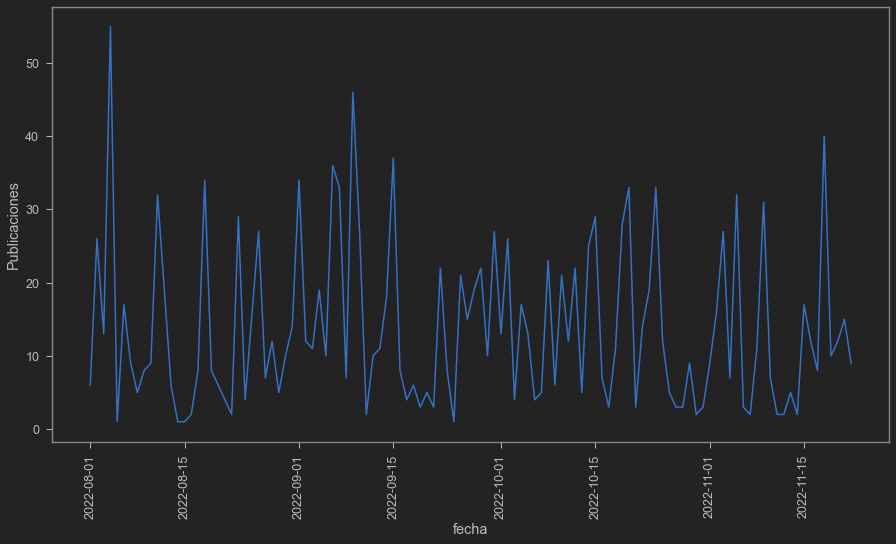

In [27]:
plt.figure(figsize=(15,8))
base_grafica.rename(inplace=True,  columns={"Menciones" : "Publicaciones"})
ax = sns.lineplot(x=base_grafica.index,y=base_grafica["Publicaciones"],data=base_grafica)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [30]:
base_graficas['mes'] = base_graficas['fecha'].apply(lambda a: pd.to_datetime(a).month)
base_grafica = base_graficas.groupby('mes').sum()
base_grafica.reset_index(inplace=True)
base_grafica

,mes,id_post_vv,id,level,Menciones
0,8,30864,5358,676,351
1,9,29808,6255,946,487
2,10,14160,4560,801,413
3,11,3060,2744,537,279


<AxesSubplot:xlabel='mes', ylabel='Menciones'>

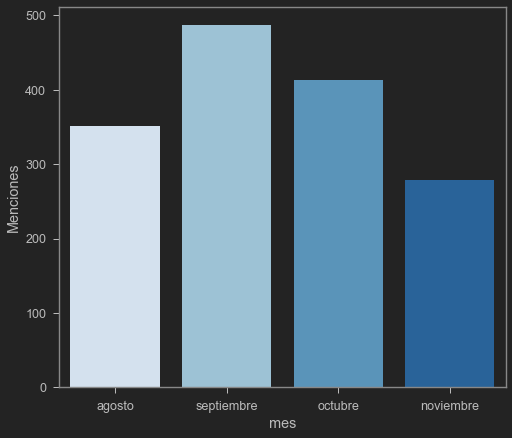

In [31]:
base = base_grafica.copy()
for index, row in base.iterrows():
    if base.loc[index,'mes'] == 1:
        base.loc[index,'mes'] = 'enero'
    elif base.loc[index,'mes'] == 2:
        base.loc[index,'mes'] = 'febrero'
    elif base.loc[index,'mes'] == 3:
        base.loc[index,'mes'] = 'marzo'
    elif base.loc[index,'mes'] == 4:
        base.loc[index,'mes'] = 'abril'
    elif base.loc[index,'mes'] == 5:
        base.loc[index,'mes'] = 'mayo'
    elif base.loc[index,'mes'] == 6:
        base.loc[index,'mes'] = 'junio'
    elif base.loc[index,'mes'] == 7:
        base.loc[index,'mes'] = 'julio'
    elif base.loc[index,'mes'] == 8:
        base.loc[index,'mes'] = 'agosto'
    elif base.loc[index,'mes'] == 9:
        base.loc[index,'mes'] = 'septiembre'
    elif base.loc[index,'mes'] == 10:
        base.loc[index,'mes'] = 'octubre'
    elif base.loc[index,'mes'] == 11:
        base.loc[index,'mes'] = 'noviembre'
    else:
        base.loc[index,'mes'] = 'diciembre'
sns.barplot(data=base,x=base.mes,y='Menciones',palette='Blues')

# Caso: Tenemos los comments como observaciones al nivel de cada post

In [ ]:
base_original = pd.read_excel('facebook_vv_ago_nov.xlsx')

In [ ]:
df = base_original.copy()
for i in df.columns:
    print(i)

In [ ]:
df['summary.total_count'].fillna(0,inplace=True)
df['like_count'].fillna('a',inplace=True)
df = df[(df['object_type'] == 'data') | (df['summary.total_count'] != 0.0)]
df = df.sort_values(by=['object_id','level'])
df = df.reset_index()
# Encontrar el valor
print(df['summary.total_count'])
lista = [row['summary.total_count'] for index,row in df.iterrows() if row['summary.total_count'] != 0.0]
print(lista)
i = 0
inicial = lista[0]
for index, row in df.iterrows():
    if row['summary.total_count'] != 0.0:
        i += 1
        if i != 190:
            siguiente = lista[i]
    if (i == 0) & (df.loc[index,'like_count'] == 'a'):
        df.loc[index, 'like_count'] = inicial
    elif (i != 0) & (df.loc[index,'like_count'] == 'a'):
        df.loc[index, 'like_count'] = siguiente
df.to_excel('facebook_vv_ago_nov_clean.xlsx')
df

In [ ]:
df['comment_count'].fillna('a',inplace=True)
valores = list()
valor = 0
comments_al_post = 0
for index, row in df.iterrows():
    if row['comment_count'] != 'a':
        valor = valor + df.loc[index, 'comment_count']
        comments_al_post += 1
    else:
        if comments_al_post != 0:
            valores.append(valor + comments_al_post)
            comments_al_post = 0
            valor = 0
valores

In [ ]:
inicial = valores[0]
i = 0
for index, row in df.iterrows():
    if (row['comment_count'] == 'a') & (i == 0):
        df.loc[index,'comment_count'] = inicial
    elif (row['comment_count'] == 'a') & (i != 0):
        i += 1
        if i < 190:
            siguiente = valores[i]
            df.loc[index,'comment_count'] = siguiente
df = df[df['object_type'] == 'data']
df.to_excel('facebook_vv_ene_jul_api_4_clean.xlsx')
df

In [ ]:
df = pd.read_excel('facebook_vv_ene_jul_api_4_clean.xlsx')
df['mensaje_procesado'] = df.message.apply(lambda s: str(s).encode('utf8','surrogateescape').decode('utf8','surrogateescape'))
df['fecha'] = df['created_time'].apply(lambda a: pd.to_datetime(a).date())
df.to_excel('facebook_vv_ene_jul_api_4_clean.xlsx')
df

# Fin de los casos

In [ ]:
base.to_excel('Base_vv_feb_abr.xlsx')

In [ ]:
df = pd.read_excel('Base_vv_feb_abr.xlsx')
df

In [34]:
df = base.copy()

In [35]:
#Eliminamos los URL: Todo lo que empieza por  HTTP
df['Clean_Text']=df['message'].replace(r"http\S+", '', regex=True)
#Eliminamos todos los hashtags
df['Clean_Text']=df['Clean_Text'].replace('#\\w+', '', regex=True)
#Eliminamos los signos de puntuación repetidos dentro de los tweets
df['Clean_Text']=df['Clean_Text'].replace(r'([^0-9a-zA-Z])\1+', r'\1', regex=True)
#Eliminamos los signos de puntuación al inicio de un tweet
df['Clean_Text']=df['Clean_Text'].replace(r'^[^0-9a-zA-Z@#]+', '', regex=True)
#Eliminamos los dobles espacios
df['Clean_Text']=df['Clean_Text'].replace(r'()\1+', r'\1\1', regex=True)
#Eliminamos las df repetivas dentro de las palabras
df['Clean_Text']=df['Clean_Text'].replace(r'(.)\1+', r'\1\1', regex=True)
# Quitar las comillas de los textos
df['Clean_Text']=df['Clean_Text'].replace('"', '', regex=True)
# Remover puntuaciones innecesarias
df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
df['Clean_Text']=df['Clean_Text'].str.replace('RT', '')
# Remover mayúsculas de inicio de texto
df['Clean_Text'] = df['Clean_Text'].map(lambda x: x.lower())
#Autores
df['Clean_Text']=df['Clean_Text'].replace(r'@\w+', '', regex=True)
df['Clean_Text']=df['Clean_Text'].str.replace('rt', '')
#Espacios
df['Clean_Text']=df['Clean_Text'].str.strip()
df['Clean_Text']=df['Clean_Text'].replace('Document_No', '')
# Exclude stopwords 
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.extend(['ser', 'haber','si','nani','Nani','hola','buenas','noche','tardes','noches','dias','gracias','tarde'])
#spanish_stopwords.extend(usuarios)
#spanish_stopwords.remove('no')
#spanish_stopwords.remove('ni')
df['Clean_Text_no_stopwords'] = df['Clean_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (spanish_stopwords) and len(word)>1]))

In [36]:
df['Clean_Text_no_stopwords']

0       caigas estafas aún fechas establecidas apeura ...
1                  lapagina embajada tramites puedo sacar
2       peles entregatón‼️ ponte pilas retira ppt 21 2...
3       dijeron llegado mensaje esperar permiso impres...
4       sé tema distinto gustaría saber información nu...
                              ...                        
1525                            mariangel camacho vasquez
1526                                   lucero garcía gali
1527               pura paja igual dan trabajo graduastes
1528    pierdan tiempo esperen instrucciones nuevo gob...
1529    pues ppt aqui colonbia aceptan sacar targeta p...
Name: Clean_Text_no_stopwords, Length: 1530, dtype: object

In [ ]:
base_graficas = df.copy()
base_graficas['Menciones'] = 1
base_grafica = base_graficas.groupby('combinado').sum()
base_grafica

In [ ]:
base_grafica['Menciones'].sort_values(ascending=True)

In [ ]:
plt.figure(figsize=(15,8))
base_grafica.rename(inplace=True,  columns={"Menciones" : "Publicaciones"})
ax = sns.lineplot(x=base_grafica.index,y=base_grafica["Publicaciones"],data=base_grafica)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [ ]:
base_grafica.sort_values('Publicaciones', inplace=True, ascending=False)
base_grafica.to_excel('Volumenes_totales.xlsx')
base_grafica

In [ ]:
base_graficas = df.copy()
base_graficas['Menciones'] = 1
base_grafica = base_graficas[base_graficas['level'] == 1].groupby('fecha').sum()
base_grafica

In [ ]:
plt.figure(figsize=(15,8))
base_grafica.rename(inplace=True,  columns={"Menciones" : "Publicaciones"})
ax = sns.lineplot(x=base_grafica.index,y=base_grafica["Publicaciones"],data=base_grafica)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [ ]:
# Word cloud general de todos los posts
series_a_str = str(df["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de los posts de voices of venezuela
df_vv = df[df['level'] == 1]
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de los comments hacia voices of venezuela
df_vv = df[df['level'] == 2]
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
df['fecha_publicacion'] = df['fecha'].dt.strftime('%d/%m/%Y')
df['fecha_publicacion']

In [ ]:
#from datetime import date, timedelta

#def daterange(start_date, end_date):
#    for n in range(int((end_date - start_date).days)):
#        yield start_date + timedelta(n)

#start_date = date(2022, 1, 1)
#end_date = date(2022, 3, 1) # Y M D
#for single_date in daterange(start_date, end_date):
#    print(single_date.strftime('%d/%m/%Y'))
    

In [44]:
df['mes'] = df['fecha'].apply(lambda a: pd.to_datetime(a).month)
df['dia'] = df['fecha'].apply(lambda a: pd.to_datetime(a).day)
df.head(5)

,id_post_vv,id,level,message,fecha,Clean_Text,Clean_Text_no_stopwords,mes,dia
0,0,0,1,🚨¡No caigas en estafas! 🚨 📆 Aún no hay fechas...,2022-11-22,no caigas en estafas 🚨 📆 aún no hay fechas est...,caigas estafas aún fechas establecidas apeura ...,11,22
1,0,0,2,Cual es la.pagina de la embajada y que tramite...,2022-11-22,cual es lapagina de la embajada y que tramites...,lapagina embajada tramites puedo sacar,11,22
2,1,1,1,‼️¡No te peles el Entregatón!‼️ 🔋 Ponte las p...,2022-11-21,no te peles el entregatón‼️ 🔋 ponte las pilas ...,peles entregatón‼️ ponte pilas retira ppt 21 2...,11,21
3,1,0,2,Yo fui y lo que me dijeron fue si no le a lleg...,2022-11-22,yo fui y lo que me dijeron fue si no le a lleg...,dijeron llegado mensaje esperar permiso impres...,11,22
4,1,1,2,Hola sé que el tema es distinto pero me gustar...,2022-11-22,hola sé que el tema es distinto pero me gustar...,sé tema distinto gustaría saber información nu...,11,22


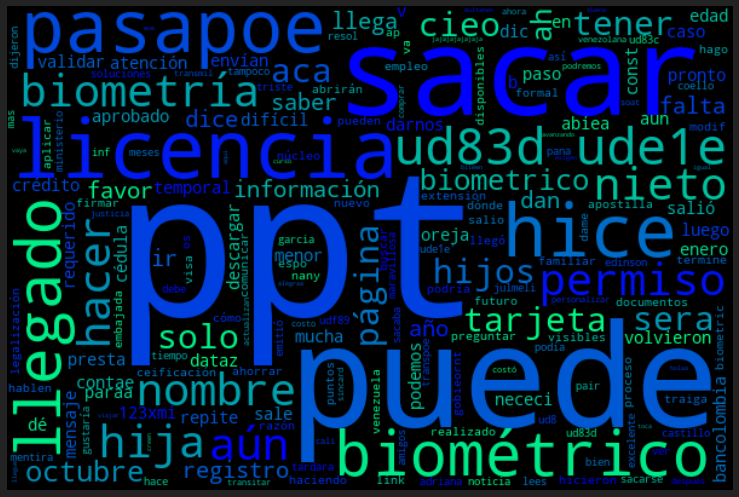

In [46]:
df_pico_1 = df[(df['dia'] == 4) & (df['mes'] == 8)]
df_pico_2 = df[(df['dia'] == 9) & (df['mes'] == 9)]
df_vv = df_pico_1
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

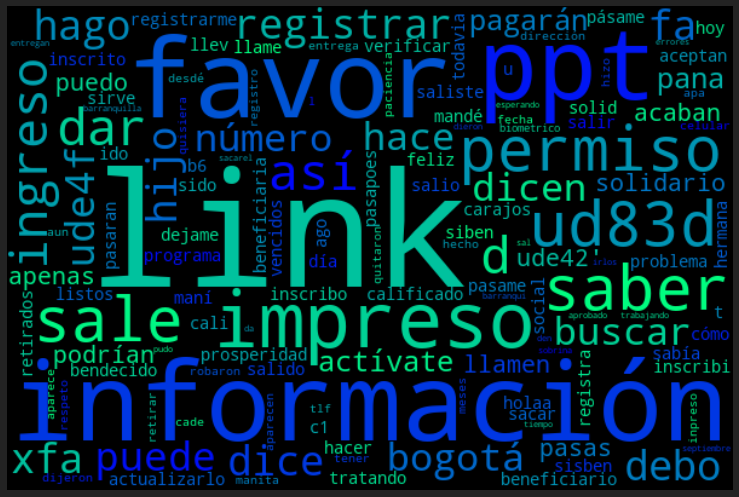

In [47]:
df_vv = df_pico_2
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [48]:
df.to_excel('facebook_vv_ago_nov.xlsx')

In [ ]:
df_quincena_1 = df[(df['dia'] <= 15) & (df['mes'] == 2)]
df_quincena_2 = df[(df['dia'] > 15) & (df['mes'] == 2)]
df_quincena_3 = df[(df['dia'] <= 15) & (df['mes'] == 3)]
df_quincena_4 = df[(df['dia'] > 15) & (df['mes'] == 3)]
df_quincena_5 = df[(df['dia'] <= 15) & (df['mes'] == 4)]
df_quincena_6 = df[(df['dia'] > 15) & (df['mes'] == 4)]
df_pico_1 = df[(df['dia'] == 19) & (df['mes'] == 4)]
df_pico_2 = df[(df['dia'] == 3) & (df['mes'] == 3)]
df_pico_3 = df[(df['dia'] == 2) & (df['mes'] == 2)]

In [ ]:
df_vv = df_pico_3
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de la primera quincena
df_vv = df_quincena_1
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de la segunda quincena
df_vv = df_quincena_2
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de la tercera quincena
df_vv = df_quincena_3
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de la cuarta quincena
df_vv = df_quincena_4
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de la quinta quincena
df_vv = df_quincena_5
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
# Word cloud general de la sexta quincena
df_vv = df_quincena_6
series_a_str = str(df_vv["Clean_Text_no_stopwords"])
series_a_str = series_a_str.replace('Document_No', '')
series_a_str = series_a_str.replace('dtype', '')
series_a_str = series_a_str.replace('object', '')
series_a_str = series_a_str.replace('Name', '')
series_a_str = series_a_str.replace('Length', '')
series_a_str = series_a_str.replace('Clean_Text_no_stopwords', '')
# Nube de palabras general
cloud=WordCloud(colormap="winter",width=600,height=400).generate(series_a_str)
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

# Volumen mensual

In [ ]:
base = pd.read_excel('facebook_vv_ene_jul_api_4_clean.xlsx')
base

In [ ]:
base['mes'] = base['fecha'].map(lambda x: str(x)[6:7] )
base['mes'] = pd.to_numeric(base['mes'])
base = base.sort_values('mes')
base['numero_mes'] = base['mes']
for index, row in base.iterrows():
    if base.loc[index,'mes'] == 1:
        base.loc[index,'mes'] = 'enero'
    elif base.loc[index,'mes'] == 2:
        base.loc[index,'mes'] = 'febrero'
    elif base.loc[index,'mes'] == 3:
        base.loc[index,'mes'] = 'marzo'
    elif base.loc[index,'mes'] == 4:
        base.loc[index,'mes'] = 'abril'
    elif base.loc[index,'mes'] == 5:
        base.loc[index,'mes'] = 'mayo'
    elif base.loc[index,'mes'] == 6:
        base.loc[index,'mes'] = 'junio'
    elif base.loc[index,'mes'] == 7:
        base.loc[index,'mes'] = 'julio'
    else:
        base.loc[index,'mes'] = 'agosto'
base['count'] = 1
base

In [ ]:
agrupada = base.groupby('mes').sum()
agrupada = agrupada.reindex(['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto'])
agrupada.head(5)

In [ ]:
sns.barplot(data=agrupada,x=agrupada.index,y='count',palette='Blues')

In [ ]:
df = pd.read_excel('facebook_vv_ene_jul_api_4_clean.xlsx')
base_graficas = df.copy()
base_graficas['Menciones'] = 1
base_grafica = base_graficas.groupby('fecha').sum()
base_grafica

In [ ]:
plt.figure(figsize=(15,8))
base_grafica.rename(inplace=True,  columns={"Menciones" : "Publicaciones"})
ax = sns.lineplot(x=base_grafica.index,y=base_grafica["Publicaciones"],data=base_grafica)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
base_grafica.rename(inplace=True,  columns={"Menciones" : "Publicaciones"})
ax = sns.lineplot(x=base_grafica.index,y=base_grafica["comment_count"],data=base_grafica)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()